# Data Science Project : Predictions on the Median Income of French Municipalities

## Project Overview and Data Understanding

### **Project Objectives**

The goal of this project is to analyze and predict the economic profile of French municipalities using socio-demographic and fiscal data. Specifically, we aim to:

- Predict the median disposable income of each municipality as a continuous variable.
- Classify municipalities into income categories — low, medium, or high — based on their median income.

To achieve this, we leverage two complementary datasets that provide a wide range of features related to demographics, education, employment, infrastructure, and fiscal characteristics. These datasets are described in the following sections.

Various machine learning techniques will be applied to model both the regression and classification tasks, with the goal of identifying the most relevant predictors and achieving robust performance.

### **Data Source**

---
#### **Source of "french_municipalities.xlsx"**
Link : https://statistiques-locales.insee.fr/#view=map1&c=indicator

This dataset was generated using the INSEE Local Statistics platform. The website allows users to:

- Select indicators from INSEE’s database,
- Choose the geographical granularity (region, department, municipality, IRIS, etc.),
- Export a custom dataset containing the selected indicators.

For this project, I selected 23 indicators at the municipal level, which are presented and analyzed below.

---
#### **Source of "fiscal.xlsx"**
Link : https://www.data.gouv.fr/fr/datasets/data-insee-sur-les-communes

This dataset also originates from INSEE. It has been pre-processed to retain only three key fiscal indicators at the municipal level, which are also detailed in the following sections.

---

#### **About INSEE**
INSEE (Institut national de la statistique et des études économiques) is the National Institute of Statistics and Economic Studies in France. It operates under the authority of the French Ministry of Economy and Finance.

INSEE is responsible for:

- Collecting and producing official statistics,
- Analyzing economic and social trends,
- Disseminating data to support public policy, research, and public understanding.

---

### **Variable Description**

---
#### **Description of "french_municipalities.xlsx"**
##### **Municipality Identification**
- `municipality_code`: Unique INSEE code identifying the municipality.
- `municipality_name`: Official name of the municipality.
##### **Demographics**
- `legal_units_2022`: Number of legal entities registered in the municipality (e.g., businesses, associations).
- `tax_households_2021`: Number of declared tax households.
- `population_2022`: Total population recorded in 2022.
##### **Age Structure**
- `pct_under_25_2021`: Percentage of residents under 25 years old.
- `pct_over_65_2021`: Percentage of residents aged 65 and over.
- `aging_index_2021`: Aging index, calculated as the number of people aged 65+ per 100 people under 20.
##### **Income**
- `median_income_2021`: Annual median disposable income per consumption unit.
##### **Economy / Enterprises**
- `business_creations_2023`: Number of businesses created in 2023.
- `pct_no_employee_2022`: Percentage of employer establishments with no employees.
- `pct_1_9_employees_2022`: Percentage of employer establishments with 1 to 9 employees.
- `jobs_at_workplace_2021`: Number of jobs located in the municipality (workplace-based).
- `pct_executives_2021`: Percentage of jobs held by executives or professionals.
##### **Education**
- `non_students_15plus_2021`: Number of individuals aged 15 and over who are not enrolled in school.
- `pct_postgrad_2021`: Percentage of this population holding a postgraduate degree (Master’s level or higher).
##### **Housing**
- `housing_units_2021`: Total number of housing units.
##### **Services / Infrastructure**
- `middle_schools_2023`: Number of middle schools in 2023.
- `pharmacies_2023`: Number of pharmacies.
- `grocery_stores_2023`: Number of grocery stores or small supermarkets.
##### **Tourism & Hospitality**
- `hotel_rooms_2025`: Number of hotel rooms available in 2025.
- `camping_spots_2025`: Number of camping spots available in 2025.
##### **Employment Infrastructure**
- `active_employers_2022`: Number of active employer establishments as of December 31, 2022.
---
#### **Description of "fiscal.xlsx"**
##### **Municipality Identification**
- `municipality_code`: Unique INSEE code identifying the municipality.
##### **Composite Scores**
- `fiscal_score`: A synthetic score reflecting the fiscal profile of the municipality, based on various economic and tax-related indicators. Higher values may indicate greater fiscal capacity or wealth.
- `urbanity_score`: A composite score representing the level of urbanization of the municipality. It is based on factors such as population density, infrastructure, and access to services.
---

## Data Preparation

### **Importing the required packages**

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, StackingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from xgboost import XGBRegressor, XGBClassifier

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

c:\Users\trist\anaconda3\lib\site-packages\dask\dataframe\utils.py:365: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\trist\anaconda3\lib\site-packages\dask\dataframe\utils.py:365: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\trist\anaconda3\lib\site-packages\dask\dataframe\utils.py:365: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

### **Loading, Renaming, and Merging Data**

In [3]:
df = pd.read_excel("french_municipalities.xlsx", skiprows=3)
fiscal = pd.read_excel("fiscal.xlsx")

df = df.rename(columns={
    "Code": "municipality_code",
    "Libellé": "municipality_name",
    "Unités légales (en nombre) 2022": "legal_units_2022",
    "Nb de ménages fiscaux 2021": "tax_households_2021",
    "Population municipale 2022": "population_2022",
    "Part des pers. âgées de - de 25 ans 2021": "pct_under_25_2021",
    "Part des pers. âgées de 65 ans ou + 2021": "pct_over_65_2021",
    "Indice de vieillissement 2021": "aging_index_2021",
    "Médiane du niveau de vie 2021": "median_income_2021",
    "Créations d'entreprises (en nombre) 2023": "business_creations_2023",
    "Part établissements sans salarié dans étab. employeurs actifs au 31/12 2022": "pct_no_employee_2022",
    "Part établissements de 1 à 9 salariés dans étab. employeurs actifs au 31/12 2022": "pct_1_9_employees_2022",
    "Nb de pers. non scolarisées de 15 ans ou + 2021": "non_students_15plus_2021",
    "Part des diplômés d'un BAC+5 ou plus dans la pop. non scolarisée de 15 ans ou + 2021": "pct_postgrad_2021",
    "Logements 2021": "housing_units_2021",
    "Nb d'emplois au lieu de travail (LT) 2021": "jobs_at_workplace_2021",
    "Part des cadres et prof. intellectuelles sup. dans le nb d’emplois au LT 2021": "pct_executives_2021",
    "Collège (en nombre) 2023": "middle_schools_2023",
    "Pharmacie (en nombre) 2023": "pharmacies_2023",
    "Supérette - Épicerie (en nombre) 2023": "grocery_stores_2023",
    "Nb de chambres dans les hôtels 2025": "hotel_rooms_2025",
    "Nombre d'emplacements de camping 2025": "camping_spots_2025",
    "Nombre d'établissements employeurs actifs au 31/12 2022": "active_employers_2022"
})

fiscal = fiscal.rename(columns={
    "CODGEO": "municipality_code",
    "Score Fiscal": "fiscal_score",
    "Score Urbanité": "urbanity_score"
})

#Merging the Two DataFrames on the INSEE Code
df = df.merge(fiscal[['municipality_code', 'fiscal_score', 'urbanity_score']], on='municipality_code', how='left')

### **Data Cleaning**

In [4]:
#List of columns to convert to numeric format
cols_to_convert = [
    'municipality_code', 'legal_units_2022', 'tax_households_2021',
    'population_2022', 'pct_under_25_2021', 'pct_over_65_2021',
    'aging_index_2021', 'median_income_2021', 'business_creations_2023',
    'pct_no_employee_2022', 'pct_1_9_employees_2022',
    'non_students_15plus_2021', 'pct_postgrad_2021', 'housing_units_2021',
    'jobs_at_workplace_2021', 'pct_executives_2021', 'middle_schools_2023',
    'pharmacies_2023', 'grocery_stores_2023', 'hotel_rooms_2025',
    'camping_spots_2025', 'active_employers_2022',
    'fiscal_score', 'urbanity_score'
]

#Convert each column to numeric, coercing errors into NaN
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

#Drop rows with any missing values (NaN)
df = df.dropna(how='any')

#Remove rows where population is zero or negative (to avoid division errors)
df = df[df['population_2022'] > 0] 
print(f"Total number of rows after cleaning : {len(df)}")
df

Total number of rows after cleaning : 29053


,municipality_code,municipality_name,legal_units_2022,tax_households_2021,population_2022,pct_under_25_2021,pct_over_65_2021,aging_index_2021,median_income_2021,business_creations_2023,...,non_students_15plus_2021,pct_postgrad_2021,housing_units_2021,jobs_at_workplace_2021,pct_executives_2021,middle_schools_2023,pharmacies_2023,grocery_stores_2023,fiscal_score,urbanity_score
0,1001.0,L'Abergement-Clémenciat,54.0,346.0,859.0,26.8,19.8,79.9,25820.0,16.0,...,630.0,6.3,372.0,75.0,0.0,0.0,0.0,0.0,59.04139,0.0
1,1002.0,L'Abergement-de-Varey,20.0,115.0,273.0,30.9,17.6,60.7,24480.0,3.0,...,188.0,13.3,175.0,29.0,19.1,0.0,0.0,0.0,59.04139,0.0
2,1004.0,Ambérieu-en-Bugey,1148.0,6855.0,15554.0,32.2,18.2,70.6,21660.0,209.0,...,10828.0,7.2,7846.0,8152.0,12.3,2.0,4.0,4.0,59.04139,37.5
3,1005.0,Ambérieux-en-Dombes,160.0,800.0,1917.0,28.3,16.6,68.2,24610.0,22.0,...,1418.0,6.5,898.0,261.0,11.8,0.0,1.0,1.0,59.04139,0.0
4,1006.0,Ambléon,4.0,51.0,114.0,15.8,28.1,228.6,24210.0,2.0,...,100.0,5.9,73.0,5.0,100.0,0.0,0.0,0.0,59.04139,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34913,97420.0,Sainte-Suzanne,1165.0,8593.0,24855.0,37.3,10.8,34.6,17720.0,254.0,...,16664.0,4.5,9630.0,5098.0,9.3,2.0,8.0,22.0,55.18519,37.5
34914,97421.0,Salazie,306.0,2472.0,7333.0,36.1,12.4,40.5,13280.0,37.0,...,5092.0,1.7,3343.0,1471.0,5.7,1.0,3.0,17.0,55.18519,0.0
34915,97422.0,Le Tampon,4576.0,31239.0,81964.0,36.5,13.3,43.7,16560.0,1009.0,...,56057.0,4.4,36635.0,18257.0,10.2,8.0,20.0,32.0,55.18519,75.0
34916,97423.0,Les Trois-Bassins,393.0,2505.0,7113.0,31.8,14.1,53.6,16680.0,88.0,...,5104.0,3.1,3095.0,1224.0,12.4,1.0,2.0,9.0,55.18519,25.0


### **Feature Engineering**

In [5]:
#Columns to Convert to "Per Capita"
cols_absolutes = [
    'legal_units_2022',
    'tax_households_2021',
    'business_creations_2023',
    'non_students_15plus_2021',
    'housing_units_2021',
    'jobs_at_workplace_2021',
    'middle_schools_2023',
    'pharmacies_2023',
    'grocery_stores_2023',
    'hotel_rooms_2025',
    'camping_spots_2025',
    'active_employers_2022'
]
#Replace each column with its per capita version and rename the columns accordingly
for col in cols_absolutes:
    df[col + '_per_capita'] = df[col] / df['population_2022']
    df.drop(columns=[col], inplace=True)

#Creating Median Income Classes
df["median_income_class"] = pd.qcut(
    df["median_income_2021"],
    q=3,
    labels=["low", "medium", "high"] #Each group contains an equal number of rows.
)
pd.set_option('display.max_columns', None)
df.head()

,municipality_code,municipality_name,population_2022,pct_under_25_2021,pct_over_65_2021,aging_index_2021,median_income_2021,pct_no_employee_2022,pct_1_9_employees_2022,pct_postgrad_2021,pct_executives_2021,fiscal_score,urbanity_score,legal_units_2022_per_capita,tax_households_2021_per_capita,business_creations_2023_per_capita,non_students_15plus_2021_per_capita,housing_units_2021_per_capita,jobs_at_workplace_2021_per_capita,middle_schools_2023_per_capita,pharmacies_2023_per_capita,grocery_stores_2023_per_capita,hotel_rooms_2025_per_capita,camping_spots_2025_per_capita,active_employers_2022_per_capita,median_income_class
0,1001.0,L'Abergement-Clémenciat,859.0,26.8,19.8,79.9,25820.0,6.7,86.7,6.3,0.0,59.04139,0.0,0.062864,0.402794,0.018626,0.733411,0.433062,0.087311,0.000000,0.000000,0.000000,0.000000,0.000000,0.017462,high
1,1002.0,L'Abergement-de-Varey,273.0,30.9,17.6,60.7,24480.0,25.0,75.0,13.3,19.1,59.04139,0.0,0.073260,0.421245,0.010989,0.688645,0.641026,0.106227,0.000000,0.000000,0.000000,0.000000,0.000000,0.014652,high
2,1004.0,Ambérieu-en-Bugey,15554.0,32.2,18.2,70.6,21660.0,8.5,69.8,7.2,12.3,59.04139,37.5,0.073807,0.440723,0.013437,0.696155,0.504436,0.524110,0.000129,0.000257,0.000257,0.002186,0.000000,0.039411,low
3,1005.0,Ambérieux-en-Dombes,1917.0,28.3,16.6,68.2,24610.0,10.9,78.3,6.5,11.8,59.04139,0.0,0.083464,0.417319,0.011476,0.739697,0.468440,0.136150,0.000000,0.000522,0.000522,0.010433,0.037559,0.023996,high
4,1006.0,Ambléon,114.0,15.8,28.1,228.6,24210.0,0.0,100.0,5.9,100.0,59.04139,0.0,0.035088,0.447368,0.017544,0.877193,0.640351,0.043860,0.000000,0.000000,0.000000,0.000000,0.000000,0.008772,high


## Predicting Median Income per Municipality: Regression

### **Modeling Preparation and Target Variable Analysis**

#### Analysis of median_income_2021

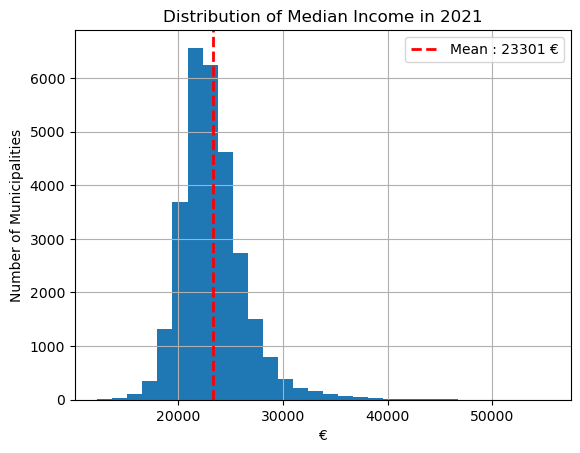

In [5]:
mean_value = df["median_income_2021"].mean()

df["median_income_2021"].hist(bins=30)
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean : {mean_value:.0f} €')
plt.title("Distribution of Median Income in 2021")
plt.xlabel("€")
plt.ylabel("Number of Municipalities")
plt.legend()
plt.show()

The histogram displays the distribution of the median standard of living across French municipalities in 2021. The x-axis represents income levels in euros (€), ranging from 0 to 50,000 €, while the y-axis shows the number of municipalities within each income bracket.

The distribution is right-skewed, meaning that most municipalities have a median income clustered in the lower to mid-range, with fewer municipalities having very high median incomes. The majority of communes appear to fall between 15,000 € and 30,000 €.

A red dashed line marks the average median income, which is approximately 23,301 €. This line helps to visualize how the income distribution compares to the national average.

This distribution suggests significant disparities in income levels across municipalities, with a concentration of communes below or around the national average, and a long tail of wealthier areas.

#### Definition of the Target Variable (y) and Predictive Features (X)

In [6]:
X = df[[
    'pct_under_25_2021',
    'pct_over_65_2021',
    'aging_index_2021',
    'pct_no_employee_2022',
    'pct_1_9_employees_2022',
    'pct_postgrad_2021',
    'pct_executives_2021',
    'legal_units_2022_per_capita',
    'tax_households_2021_per_capita',
    'business_creations_2023_per_capita',
    'non_students_15plus_2021_per_capita',
    'housing_units_2021_per_capita',
    'jobs_at_workplace_2021_per_capita',
    'middle_schools_2023_per_capita',
    'pharmacies_2023_per_capita',
    'grocery_stores_2023_per_capita',
    'hotel_rooms_2025_per_capita',
    'camping_spots_2025_per_capita',
    'active_employers_2022_per_capita',
    'fiscal_score',
    'urbanity_score'
]]

y = df['median_income_2021']

#### Splitting the Data into Training and Test Sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Model Training and Evaluation**

#### First Regression Method: Decision Tree

In [8]:
regressor = DecisionTreeRegressor(
    max_depth=5,
    min_samples_leaf=20,
    min_samples_split=20,
    random_state=42
)

regressor.fit(X_train, y_train)

nombre_de_feuilles = regressor.get_n_leaves()
print(f'Number of Leaf Nodes : {nombre_de_feuilles}')

Number of Leaf Nodes : 32


In [9]:
y_pred = regressor.predict(X_test)

#Calculation and display of key metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("Evaluation of the model :")
print(f"MAE (Mean Absolute Error)               : {mae:.2f} €")
print(f"MSE (Mean Squared Error)                : {mse:.2f}")
print(f"RMSE (Root Mean Squared Error)          : {rmse:.2f} €")
print(f"R² Score (Coefficient of Determination) : {r2:.4f}")

Evaluation of the model :
MAE (Mean Absolute Error)               : 1604.50 €
MSE (Mean Squared Error)                : 5019500.54
RMSE (Root Mean Squared Error)          : 2240.42 €
R² Score (Coefficient of Determination) : 0.5072


**Evaluation of the model :**

MAE (~1,600€): On average, the model's predictions deviate from the actual median income by about 1600€ per municipality.  
  Compared to the national average of 23301€, this represents a relative error of approximately 7.3%, which indicates moderate accuracy.

MSE (~5019500): The Mean Squared Error penalizes larger errors more heavily due to squaring. This high value suggests that while many predictions are close to the actual values, some municipalities have significantly larger prediction errors.

RMSE (~2325€): The Root Mean Squared Error gives an idea of the typical size of the prediction error. An RMSE of over 2300€ implies that some predictions deviate by more than 10%, especially in higher-income municipalities.

R² (0.5073): The model explains about 51% of the variance in median incomes across municipalities. This means it captures a meaningful trend, but more than half of the variability remains unexplained, suggesting room for improvement or the need for additional features.

In [10]:
#Definition of hyperparameters to test
param_grid = {
    'max_depth': [5, 6, 7],
    'min_samples_split': [15, 20],
    'min_samples_leaf': [5, 10]
}

#Model initialization
regressor = DecisionTreeRegressor(random_state=42)

#Grid search
grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

#Model training
grid_search.fit(X_train, y_train)

#Retrieve the best model
best_model = grid_search.best_estimator_

#Results
print("Best Hyperparameters Found :")
print(grid_search.best_params_)

nombre_de_feuilles = best_model.get_n_leaves()
print(f'Number of Leaf Nodes : {nombre_de_feuilles}')

Best Hyperparameters Found :
{'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 15}
Number of Leaf Nodes : 106


**Hyperparameters Found** :

max_depth: 7 : This limits the maximum depth of the tree to 7 levels, preventing it from becoming too complex and overfitting the training data.

min_samples_leaf: 10 : Each leaf node must contain at least 10 samples, which helps avoid splitting into very small groups. This improves the model’s stability and generalization.

min_samples_split: 15 : A node must have at least 15 samples to be split into two children. This prevents the tree from making overly fine and unnecessary splits in smaller branches.

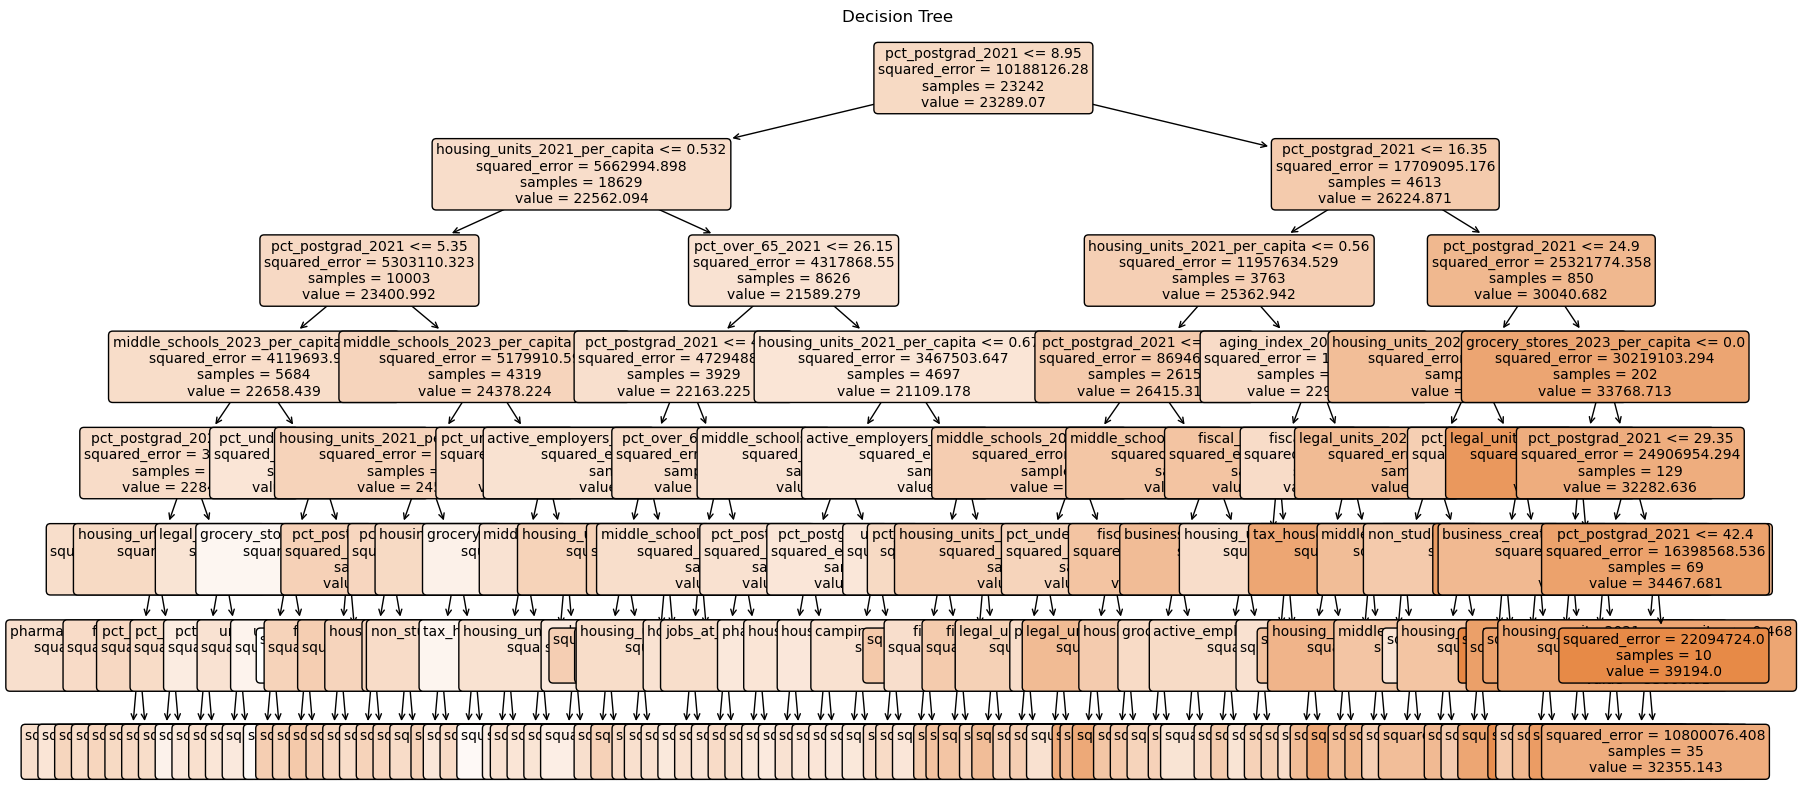

In [11]:
#Adjusts the size according to the complexity of the tree
plt.figure(figsize=(20, 10))

plot_tree(
    best_model,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree")
plt.show()

In [12]:
#Calculation and display of key metrics for the new model
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("Evaluation of the model :")
print(f"MAE (Mean Absolute Error)               : {mae:.2f} €")
print(f"MSE (Mean Squared Error)                : {mse:.2f}")
print(f"RMSE (Root Mean Squared Error)          : {rmse:.2f} €")
print(f"R² Score (Coefficient of Determination) : {r2:.4f}")

Evaluation of the model :
MAE (Mean Absolute Error)               : 1534.47 €
MSE (Mean Squared Error)                : 4653873.48
RMSE (Root Mean Squared Error)          : 2157.28 €
R² Score (Coefficient of Determination) : 0.5431


**Evaluation of the new model :**

MAE (~1450€): On average, the model's predictions deviate from the actual median income by about 1450€ per municipality.  
  Compared to the national average of 23,301€, this represents a relative error of approximately 6.3%, which indicates moderate accuracy.

MSE (~4230000): The Mean Squared Error penalizes larger errors more heavily due to squaring. This high value suggests that while many predictions are close to the actual values, some municipalities have significantly larger prediction errors.

RMSE (~2050): The Root Mean Squared Error gives an idea of the typical size of the prediction error. An RMSE of over 2050€ implies that some predictions deviate by more than 10%, especially in higher-income municipalities.

R² (0.5847): The model explains about 58.5% of the variance in median incomes across municipalities. This means it captures a meaningful trend, but more than one third of the variability remains unexplained, suggesting room for improvement or the need for additional features.

#### Second Regression Method: Random Forest

In [13]:
#Random Forest model
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)
print("Random Forest model evaluation :")
print(f"MAE (Mean Absolute Error)               : {mae:.2f} €")
print(f"MSE (Mean Squared Error)                : {mse:.2f}")
print(f"RMSE (Root Mean Squared Error)          : {rmse:.2f} €")
print(f"R² Score (Coefficient of Determination) : {r2:.4f}")

Random Forest model evaluation :
MAE (Mean Absolute Error)               : 1343.26 €
MSE (Mean Squared Error)                : 3575861.87
RMSE (Root Mean Squared Error)          : 1890.99 €
R² Score (Coefficient of Determination) : 0.6489


In [14]:
#Definition of hyperparameters to test
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [8, 10, 12],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

#Model initialization
rf = RandomForestRegressor(random_state=42)

#Grid search
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

#Model training
grid_search_rf.fit(X_train, y_train)
print("Best Hyperparameters Found :")
print(grid_search_rf.best_params_)

#Retrieve the best model
best_rf = grid_search_rf.best_estimator_

y_pred_best = best_rf.predict(X_test)

r2 = r2_score(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)
print("Random Forest new model evaluation :")
print(f"MAE (Mean Absolute Error)               : {mae:.2f} €")
print(f"MSE (Mean Squared Error)                : {mse:.2f}")
print(f"RMSE (Root Mean Squared Error)          : {rmse:.2f} €")
print(f"R² Score (Coefficient of Determination) : {r2:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 

#### Third Regression Method: XGBoost

In [15]:
#XGBoost model
xgb = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Regressor")
print(f"R²    : {r2_score(y_test, y_pred_xgb):.4f}")
print(f"MAE   : {mean_absolute_error(y_test, y_pred_xgb):.2f} €")
print(f"RMSE  : {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f} €")

XGBoost Regressor
R²    : 0.7280
MAE   : 1182.79 €
RMSE  : 1664.28 €


In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 5]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='r2',
    cv=3,               # 3 plis = plus rapide
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

print("Best XGBoost hyperparameters :")
print(grid_search_xgb.best_params_)
best_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

r2 = r2_score(y_test, y_pred_best_xgb)
mae = mean_absolute_error(y_test, y_pred_best_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))

print(" Evaluation of best XGBoost model :")
print(f"R²    : {r2:.4f}")
print(f"MAE   : {mae:.2f} €")
print(f"RMSE  : {rmse:.2f} €")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
⚡ Meilleurs hyperparamètres XGBoost :
{'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500}

✅ Évaluation du meilleur modèle XGBoost :
R²    : 0.7396
MAE   : 1152.50 €
RMSE  : 1628.68 €


#### Other Regression Methods: Bests models of these methods

##### Ridge Regression

Ridge Regression is a linear model that uses L2 regularization to prevent overfitting. It adds a penalty proportional to the square of the magnitude of the coefficients, which helps reduce their size but does not set any of them to zero. It's especially useful when features are highly correlated or when the model tends to overfit.

In [16]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("Ridge Regression")
print(f"R²    : {r2_score(y_test, y_pred_ridge):.4f}")
print(f"MAE   : {mean_absolute_error(y_test, y_pred_ridge):.2f} €")
print(f"RMSE  : {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.2f} €")

Ridge Regression
R²    : 0.4952
MAE   : 1590.00 €
RMSE  : 2267.52 €


##### Lasso Regression

Lasso Regression is another linear model, but it uses L1 regularization. This type of penalty encourages sparsity in the coefficients, meaning it can reduce some of them to exactly zero. As a result, Lasso not only helps with overfitting but also performs feature selection by excluding irrelevant variables.

In [17]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

print("Lasso Regression")
print(f"R²    : {r2_score(y_test, y_pred_lasso):.4f}")
print(f"MAE   : {mean_absolute_error(y_test, y_pred_lasso):.2f} €")
print(f"RMSE  : {np.sqrt(mean_squared_error(y_test, y_pred_lasso)):.2f} €")

Lasso Regression
R²    : 0.4933
MAE   : 1590.08 €
RMSE  : 2271.72 €


##### GradientBoostingRegressor

Gradient Boosting Regressor builds an ensemble of decision trees sequentially. Each new tree is trained to correct the errors of the previous ones using gradient descent on the loss function. It is highly flexible and powerful for both linear and non-linear data, but it can be slower to train and more sensitive to hyperparameters.

In [18]:
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=8, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

print("Gradient Boosting")
print(f"R²    : {r2_score(y_test, y_pred_gbr):.4f}")
print(f"MAE   : {mean_absolute_error(y_test, y_pred_gbr):.2f} €")
print(f"RMSE  : {np.sqrt(mean_squared_error(y_test, y_pred_gbr)):.2f} €")

Gradient Boosting
R²    : 0.7202
MAE   : 1192.76 €
RMSE  : 1688.16 €


##### Support Vector Regression

SVR is a regression version of Support Vector Machines. It tries to find a function that fits the data within a certain margin (epsilon) while keeping the model as flat as possible. It can handle non-linear relationships using kernels but is typically slower and better suited for smaller datasets.

In [19]:
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, epsilon=500))
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

print("Support Vector Regression")
print(f"R²    : {r2_score(y_test, y_pred_svr):.4f}")
print(f"MAE   : {mean_absolute_error(y_test, y_pred_svr):.2f} €")
print(f"RMSE  : {np.sqrt(mean_squared_error(y_test, y_pred_svr)):.2f} €")

Support Vector Regression
R²    : 0.5403
MAE   : 1456.05 €
RMSE  : 2163.72 €


##### LGBMRegressor

LGBMRegressor is a fast, efficient gradient boosting framework based on decision trees. It uses techniques like histogram-based learning and leaf-wise tree growth to optimize training speed and memory usage. It performs extremely well on large datasets and handles categorical features natively.

In [20]:
lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    random_state=42
)
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)

print("LightGBM")
print(f"R²    : {r2_score(y_test, y_pred_lgb):.4f}")
print(f"MAE   : {mean_absolute_error(y_test, y_pred_lgb):.2f} €")
print(f"RMSE  : {np.sqrt(mean_squared_error(y_test, y_pred_lgb)):.2f} €")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4827
[LightGBM] [Info] Number of data points in the train set: 23242, number of used features: 21
[LightGBM] [Info] Start training from score 23289.070218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

##### CatBoostRegressor

CatBoostRegressor is a gradient boosting model developed by Yandex, known for handling categorical variables without preprocessing. It is robust, accurate, and requires less parameter tuning compared to other boosting methods. It's especially useful when your data includes many categorical features.

In [21]:
cat = CatBoostRegressor(
    iterations=1700,
    learning_rate=0.042,
    depth=7,
    verbose=0,
    random_state=42
)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)

print("CatBoost")
print(f"R²    : {r2_score(y_test, y_pred_cat):.4f}")
print(f"MAE   : {mean_absolute_error(y_test, y_pred_cat):.2f} €")
print(f"RMSE  : {np.sqrt(mean_squared_error(y_test, y_pred_cat)):.2f} €")

CatBoost
R²    : 0.7418
MAE   : 1155.02 €
RMSE  : 1621.74 €


##### StackingRegressorv (XGBRegressor+GradientBoostingRegressor+Lasso Regression)

StackingRegressor combines multiple regression models to improve performance. It trains base models on the data and then uses another model (called the meta-learner) to learn how to best combine their predictions. This ensemble approach can increase accuracy by leveraging the strengths of different models.

In [ ]:
xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
lasso = Lasso(alpha=0.1)

stack = StackingRegressor(
    estimators=[
        ('xgb', xgb),
        ('gbr', gbr),
        ('lasso', lasso)
    ],
    final_estimator=Ridge()
)

stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
print("Stacking Regressor")
print(f"R²    : {r2_score(y_test, y_pred_stack):.4f}")
print(f"MAE   : {mean_absolute_error(y_test, y_pred_stack):.2f} €")
print(f"RMSE  : {np.sqrt(mean_squared_error(y_test, y_pred_stack)):.2f} €")

Stacking Regressor
R²    : 0.7011
MAE   : 1236.38 €
RMSE  : 1744.63 €


### **Conlusion**

In this part, we set out to analyze and predict the economic profile of French municipalities through regression, using rich socio-demographic and fiscal data. Our objective was to accurately predict the median disposable income as a continuous variable.

To address this, we explored a variety of machine learning models, ranging from linear regressors and decision trees to more advanced ensemble techniques. After rigorous evaluation, CatBoostRegressor emerged as the most effective model. Its ability to natively handle categorical features, combined with strong predictive performance and minimal preprocessing requirements, made it particularly well-suited to the complexity and diversity of our dataset.

## Predicting Median Income Class per Municipality: Classification

### **Modeling Preparation and Target Variable Analysis**

#### Analysis of median_income_class

In [6]:
df.groupby("median_income_class")["median_income_2021"].mean()

median_income_class
low       20371.452128
medium    22882.659640
high      26657.705749
Name: median_income_2021, dtype: float64

#### Definition of the Target Variable (y) and Predictive Features (X)

In [7]:
X = df[[
    'pct_under_25_2021',
    'pct_over_65_2021',
    'aging_index_2021',
    'pct_no_employee_2022',
    'pct_1_9_employees_2022',
    'pct_postgrad_2021',
    'pct_executives_2021',
    'legal_units_2022_per_capita',
    'tax_households_2021_per_capita',
    'business_creations_2023_per_capita',
    'non_students_15plus_2021_per_capita',
    'housing_units_2021_per_capita',
    'jobs_at_workplace_2021_per_capita',
    'middle_schools_2023_per_capita',
    'pharmacies_2023_per_capita',
    'grocery_stores_2023_per_capita',
    'hotel_rooms_2025_per_capita',
    'camping_spots_2025_per_capita',
    'active_employers_2022_per_capita',
    'fiscal_score',
    'urbanity_score'
]]

y = df['median_income_class']

#### Splitting the Data into Training and Test Sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Model Training and Evaluation**

#### **First Classification Method: Decision Tree**

In [ ]:
decision_tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    min_samples_leaf=20,
    min_samples_split=20,
    random_state=42
)

decision_tree.fit(X_train, y_train)
nombre_de_feuilles = decision_tree.tree_.n_leaves
print(f'Number of Leaf Nodes : {nombre_de_feuilles}')

Nombre de feuilles : 32


Accuracy sur test : 0.6045
Classification rapport :
              precision    recall  f1-score   support

        high       0.77      0.61      0.68      1953
         low       0.58      0.77      0.66      1875
      medium       0.49      0.44      0.47      1983

    accuracy                           0.60      5811
   macro avg       0.62      0.61      0.60      5811
weighted avg       0.62      0.60      0.60      5811



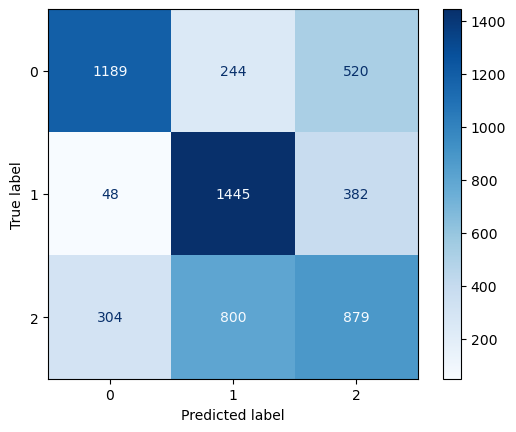

In [ ]:
y_pred = decision_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test : {accuracy:.4f}")
print("Classification rapport :")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ Meilleurs hyperparamètres trouvés :
{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 15}

🎯 Accuracy sur test : 0.6214

📋 Rapport de classification :
              precision    recall  f1-score   support

        high       0.74      0.65      0.69      1953
         low       0.62      0.72      0.67      1875
      medium       0.52      0.50      0.51      1983

    accuracy                           0.62      5811
   macro avg       0.63      0.62      0.62      5811
weighted avg       0.62      0.62      0.62      5811



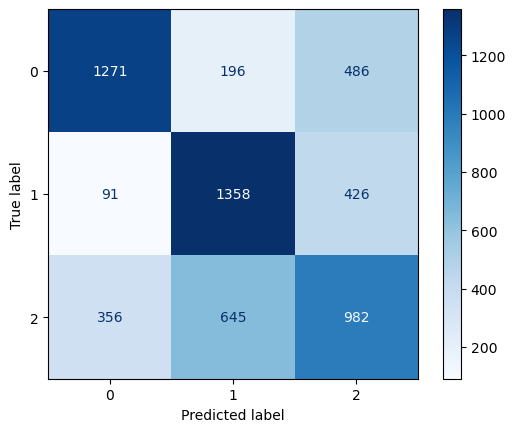

In [ ]:
param_grid = {
    'max_depth': [5, 6, 7],
    'min_samples_split': [15, 20],
    'min_samples_leaf': [10, 15],
    'criterion': ['gini', 'entropy']
}

dtc = DecisionTreeClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_dtc = grid_search.best_estimator_
print("Best hyperparameters found :")
print(grid_search.best_params_)

y_pred = best_dtc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test : {accuracy:.4f}")
print("Classification rapport :")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

#### **Second Classification Method: Random Forest**

Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Best parameters for Random Forest:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

🎯 Accuracy: 0.6510

📋 Classification Report:
              precision    recall  f1-score   support

        high       0.75      0.72      0.74      1953
         low       0.67      0.71      0.69      1875
      medium       0.54      0.52      0.53      1983

    accuracy                           0.65      5811
   macro avg       0.65      0.65      0.65      5811
weighted avg       0.65      0.65      0.65      5811



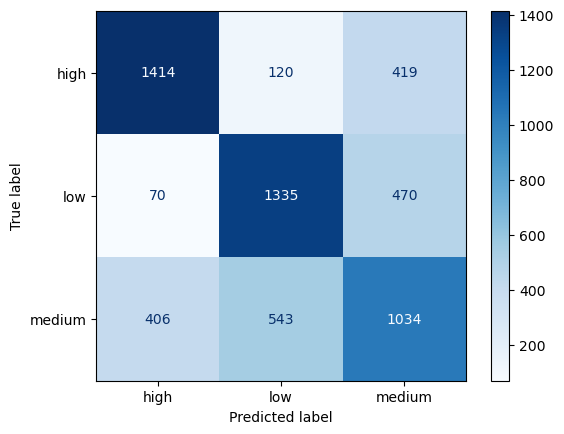

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [10, 20]
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best parameters for Random Forest:")
print(grid_search.best_params_)

y_pred = best_rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap="Blues")

🎯 Accuracy: 0.6579
📋 Classification Report:
              precision    recall  f1-score   support

        high       0.75      0.72      0.74      1953
         low       0.67      0.72      0.70      1875
      medium       0.55      0.53      0.54      1983

    accuracy                           0.66      5811
   macro avg       0.66      0.66      0.66      5811
weighted avg       0.66      0.66      0.66      5811



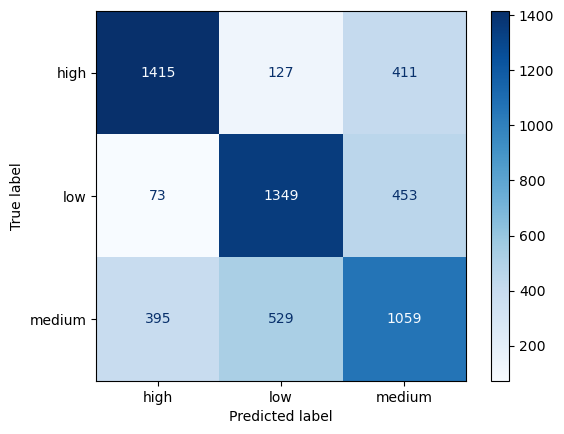

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues")

#### **Third Classification Method: Logistic Regression**

Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\trist\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Best parameters for Logistic Regression:
{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

🎯 Accuracy: 0.6102

📋 Classification Report:
              precision    recall  f1-score   support

        high       0.71      0.70      0.71      1953
         low       0.61      0.67      0.64      1875
      medium       0.50      0.46      0.48      1983

    accuracy                           0.61      5811
   macro avg       0.61      0.61      0.61      5811
weighted avg       0.61      0.61      0.61      5811



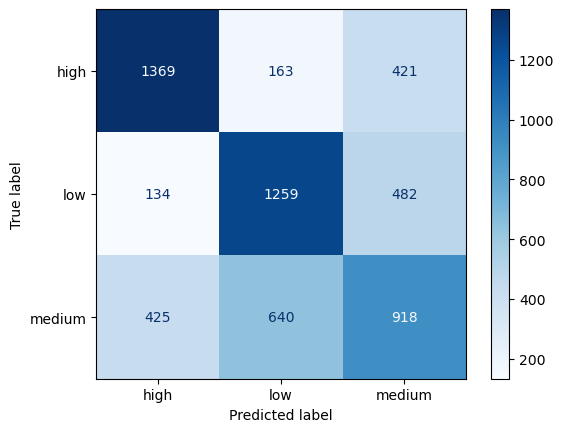

In [ ]:
param_grid = {
    'C': [0.1, 1.0, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
grid_search = GridSearchCV(lr, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_lr = grid_search.best_estimator_
print("Best parameters for Logistic Regression:")
print(grid_search.best_params_)

y_pred = best_lr.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, cmap="Blues")

#### **Other Classification Methods**

##### Support Vector Classifier

🎯 Accuracy: 0.6021
📋 Classification Report:
              precision    recall  f1-score   support

        high       0.73      0.63      0.67      1953
         low       0.61      0.63      0.62      1875
      medium       0.49      0.55      0.52      1983

    accuracy                           0.60      5811
   macro avg       0.61      0.60      0.61      5811
weighted avg       0.61      0.60      0.61      5811



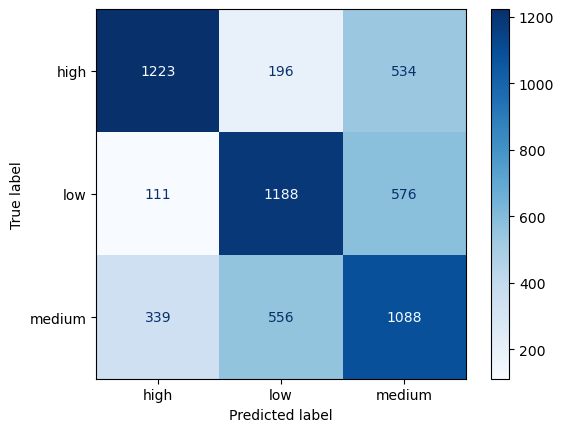

In [ ]:
svc = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test, cmap="Blues")

##### Gradient Boosting Classifier

Accuracy: 0.6730
📋 Classification Report:
              precision    recall  f1-score   support

        high       0.78      0.75      0.76      1953
         low       0.67      0.75      0.71      1875
      medium       0.57      0.53      0.55      1983

    accuracy                           0.67      5811
   macro avg       0.67      0.67      0.67      5811
weighted avg       0.67      0.67      0.67      5811



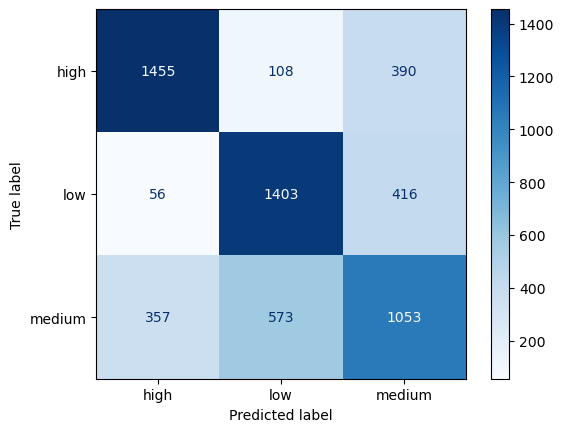

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(gbc, X_test, y_test, cmap="Blues")

##### Cat Boost Classifier

CatBoost Accuracy: 0.6992
              precision    recall  f1-score   support

        high       0.79      0.77      0.78      1953
         low       0.72      0.75      0.74      1875
      medium       0.59      0.57      0.58      1983

    accuracy                           0.70      5811
   macro avg       0.70      0.70      0.70      5811
weighted avg       0.70      0.70      0.70      5811



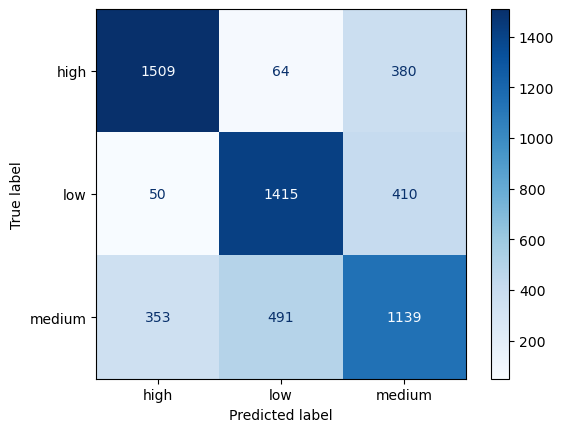

In [ ]:
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"CatBoost Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

##### XGBC Classifier

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"⚡ XGBoost Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['high' 'low' 'medium']

##### LGBM Classifier


🌟 LightGBM Accuracy: 0.7035

📋 Classification Report:
              precision    recall  f1-score   support

        high       0.79      0.78      0.78      1953
         low       0.72      0.76      0.74      1875
      medium       0.60      0.57      0.58      1983

    accuracy                           0.70      5811
   macro avg       0.70      0.70      0.70      5811
weighted avg       0.70      0.70      0.70      5811



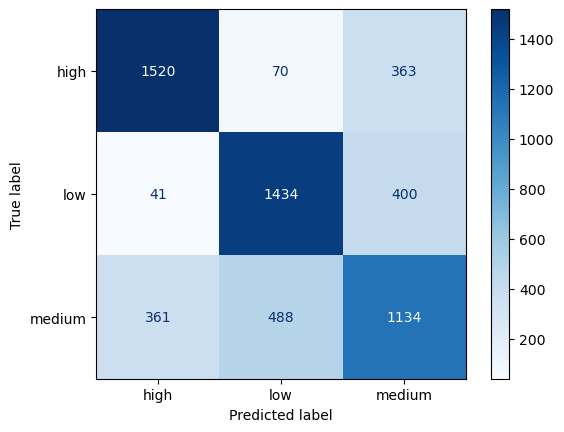

In [ ]:
lgbm = LGBMClassifier(
    n_estimators=182,
    max_depth=10,
    learning_rate=0.1,
    num_leaves=50,
    subsample=1,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"LightGBM Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

##### MLPClassifier

🧠 MLP Accuracy: 0.5849
              precision    recall  f1-score   support

        high       0.84      0.48      0.61      1953
         low       0.70      0.51      0.59      1875
      medium       0.45      0.76      0.57      1983

    accuracy                           0.58      5811
   macro avg       0.67      0.58      0.59      5811
weighted avg       0.66      0.58      0.59      5811



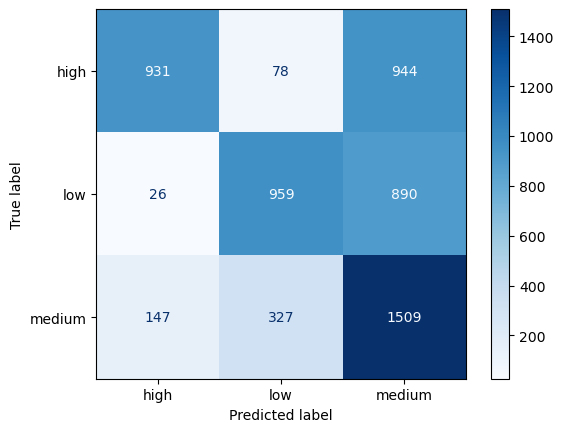

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"MLP Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

### **Conclusion**

In this part, we set out to model and understand the economic landscape of French municipalities by classifying them into income categories (low, medium, high). Using comprehensive socio-demographic and fiscal datasets, we explored classification tasks to gain actionable insights into local economic disparities.

After experimenting with a wide range of machine learning models, including decision trees, support vector machines, and ensemble methods—the LGBMClassifier (Light Gradient Boosting Machine) achieved the best results for the classification task. Its ability to handle high-dimensional data efficiently, combined with fast training time and strong predictive power, made it the optimal choice for this project. LGBM also offered excellent flexibility in tuning and interpretability through feature importance analysis. This outcome highlights the value of gradient boosting algorithms in real-world tabular data problems, especially when performance and scalability are key.

## Conclusion and perspectives

This project set out to explore and predict the economic structure of French municipalities through the lens of data science. By leveraging rich socio-demographic and fiscal data, our goal was twofold: first, to predict the median disposable income of each municipality as a continuous variable (regression task), and second, to classify municipalities into income categories (low, medium, high) for easier interpretability and policy relevance (classification task).

Throughout the project, we integrated two complementary datasets encompassing a wide range of features, including population demographics, education levels, employment rates, infrastructure quality, and fiscal indicators. These features provided a comprehensive snapshot of each municipality, allowing us to develop robust and meaningful models.

We employed a variety of machine learning techniques, ranging from traditional linear models to more advanced ensemble methods. Each model was evaluated rigorously using appropriate metrics such as R² for regression, and accuracy, precision, recall, and F1-score for classification. Extensive preprocessing and feature engineering were carried out to ensure data quality and improve model performance.

Among the models tested, LGBMClassifier emerged as the most effective for classification, delivering strong accuracy and generalization capabilities. Its performance, combined with its scalability and ability to handle large datasets efficiently, made it particularly suitable for this complex, high-dimensional task.

Beyond technical performance, this project highlights the power of data science in tackling socially relevant issues. The ability to model and predict economic disparities at the municipal level can be of immense value to policymakers, researchers, and urban planners. These models can help identify under-resourced areas, guide targeted interventions, and promote more equitable distribution of resources.

In conclusion, this study not only achieved its predictive goals but also demonstrated how data-driven approaches can provide valuable insights into socio-economic dynamics. As data becomes increasingly available and accessible, such analytical tools will be essential in shaping fairer and more informed public policies.

Futhermore, the models could be improved in the future by adding more data and by adjusting more the parameters of our models.